In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
from params import *
import mne
import seaborn as sns

**Deux choses :**
- Trouver la modulante des fuseaux dans le signal cérébral
- Voir si cette modulante est modulée par la respi

**Pour trouver la modulante des fuseaux :**
- Récupérer la phase de différentes bandes de fréquence
- Compter le timing des fuseaux par rapport à ces phases

**Pour voir si cette modulante est modulée par la respi :**
- PAC de la respi sur les oscillations cérébrales
- Voir ce qui se passe par rapport à la possible modulante des fuseaux ?

In [3]:
def get_da_phase(da, stage, f_start = 0.2, f_stop = 10, step = 0.1):
    chan_sig = da.loc[stage,'Fp2-C4',:].values
    da_precompute = None
    filter_width = step

    freqs = np.arange(f_start * 10, f_stop*10, filter_width * 10) / 10
    for fi in freqs:
        fi = round(fi, 1)
        # print(fi)
        if fi - filter_width <= 0:
            low = None
        else:
            low = fi - filter_width
        high = fi + filter_width
        # print(low , high)
        fi_filtered = gh.filter_sig(chan_sig, fs=srate, low = low, high = high)
        fi_phase = gh.get_phase(fi_filtered)
        if da_precompute is None:
            da_precompute = gh.init_da({'feature':['phase','filtered'],'freq':freqs,'time':da.coords['time'].values})
        da_precompute.loc['phase',fi,:] = fi_phase
        da_precompute.loc['filtered',fi,:] = fi_filtered
    return da_precompute

In [4]:
def load_spindles(patient , stage_to_study):
    spindle_file = f'../df_analyse/spindles_{patient}.xlsx'
    spindles = pd.read_excel(spindle_file).drop(columns = 'Unnamed: 0')
    spindles = spindles[spindles['stage'] == stage_to_study]
    return spindles

In [5]:
def count_spindles_by_phase_bin(nbins, patient, spindles, df_cycles, cycle_spindled, show=False):
    spindles_times = spindles['Peak']
    
    count = []

    for cycle in cycle_spindled:
        
        start = df_cycles.loc[cycle,'start time']
        stop = df_cycles.loc[cycle,'stop time']

        phases_timings = np.linspace(start, stop, nbins + 1)
        
        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values
        
        for spindle_time in spindles_of_the_cycle:
            for i, phase_start in enumerate(phases_timings):
                if phase_start != phases_timings[-1]:
                    phase_stop = phases_timings[i + 1]
                    if spindle_time >= phase_start and spindle_time < phase_stop:
                        count.append(i)
                        
    phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
    phase_count = phase_count.to_frame().T
    phase_count.insert(0 , 'norm' , 'no')
    phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
    phase_count_norm = phase_count_norm.to_frame().T
    phase_count_norm.insert(0 , 'norm' , 'yes')
    
    df_concat = pd.concat([phase_count, phase_count_norm], axis = 0)
    
    df_concat.insert(0 , 'patient', patient)

    return df_concat

In [6]:
def get_cycles_from_phase(phase):
    gradient = -1
    cycles = np.where(np.gradient(phase) < gradient)[0][::2]
    
    c = []
    for i in range(0, cycles.size):
        if i == cycles.size -1:
            break
        start_idx = cycles[i]
        stop_idx =  cycles[i+1]
        start_time = start_idx / srate
        stop_time = stop_idx / srate
        duration = stop_time - start_time
        c.append([start_idx ,stop_idx, start_time, stop_time , duration])
    df_features_of_fi = pd.DataFrame(c, columns = ['start idx','stop idx', 'start time', 'stop time', 'duration'])
    return df_features_of_fi

In [7]:
def which_cycle_find_spindle(spindles, df_cycles):
    spindles_times = spindles['Peak'].values

    count = []

    for cycle in range(df_cycles.shape[0]):

        start = df_cycles.loc[cycle,'start time']
        stop = df_cycles.loc[cycle,'stop time']
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < stop:
                count.append(cycle)
    cycles_with_spindle = pd.Series(count).unique()

    return cycles_with_spindle

In [8]:
def mi_from_fi(fi, da, spindles, show = False):
    df_features_of_fi = get_cycles_from_phase(phase=da.loc['phase',fi,:])
    cycles_with_spindle = which_cycle_find_spindle(spindles, df_features_of_fi)
    count_by_bin_18 = count_spindles_by_phase_bin(nbins=18, patient=patient, spindles=spindles, df_cycles=df_features_of_fi, cycle_spindled=cycles_with_spindle)
    values_18 = count_by_bin_18[count_by_bin_18['norm'] == 'yes'].drop(columns=['patient','norm']).values[0]
    mi = gh.Modulation_Index(values_18, show = show)
    return mi

In [9]:
def get_fi_mi_from_patient(patient, start=0.2, stop = 10, step = 0.1):
    stage = 'N2'
    da_data = xr.load_dataarray(f'../dataarray/da_staged_{patient}.nc')
    da_precompute = get_da_phase(da_data, stage, f_start = start, f_stop = stop, step = step)
    spindles = load_spindles(patient , stage)

    rows = []
    for fi in da_precompute.coords['freq'].values:
        print(fi)
        mi = mi_from_fi(fi=fi, da=da_precompute, spindles=spindles)
        rows.append([patient, fi, mi])
    df_fi_mi = pd.DataFrame(rows, columns = ['patient','freq', 'mi'])
    
    return df_fi_mi

In [5]:
# concat = []
# for patient in patients:
#     df_patient = get_fi_mi_from_patient(patient)
#     concat.append(df_patient)
# df_all = pd.concat(concat)

In [6]:
# df_all.to_excel('../df_analyse/fi_mi_all.xlsx')

In [7]:
df_all = pd.read_excel('../df_analyse/fi_mi_all.xlsx', index_col = 0)

In [37]:
df_all

,patient,freq,mi
0,P1,0.2,0.004346
1,P1,0.3,0.006412
2,P1,0.4,0.003777
3,P1,0.5,0.001352
4,P1,0.6,0.001475
...,...,...,...
93,P10,9.5,0.012668
94,P10,9.6,0.012415
95,P10,9.7,0.012058
96,P10,9.8,0.013906


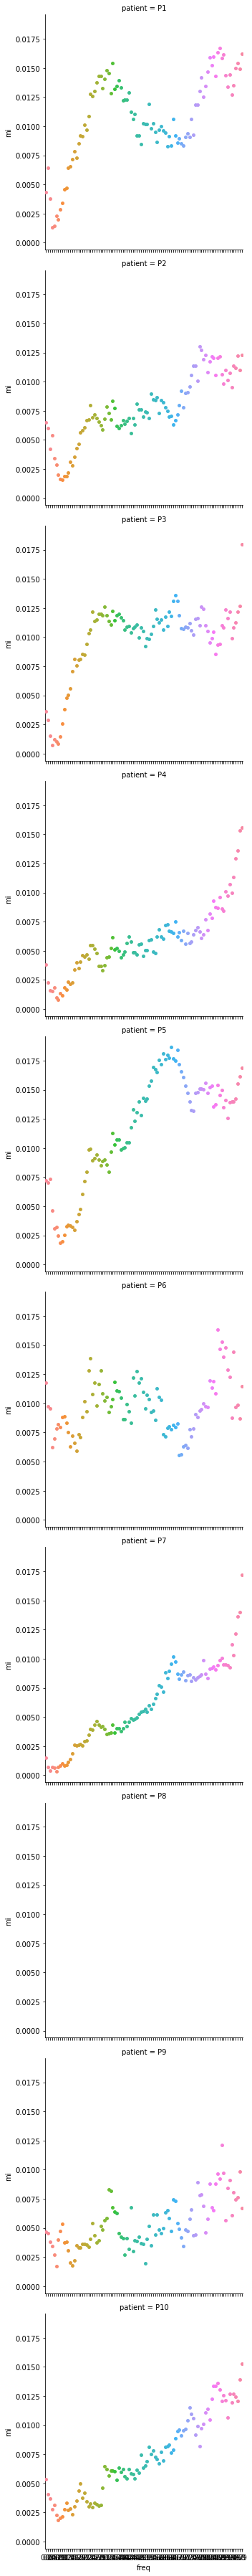

In [8]:
sns.catplot(data=df_all, x = 'freq', y = 'mi', row = 'patient', kind = 'swarm')

<AxesSubplot:xlabel='freq', ylabel='mi'>

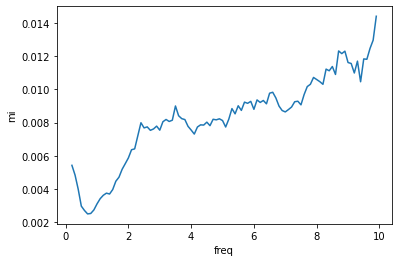

In [9]:
sns.lineplot(data=df_all.groupby('freq').mean().reset_index() , x='freq', y = 'mi')

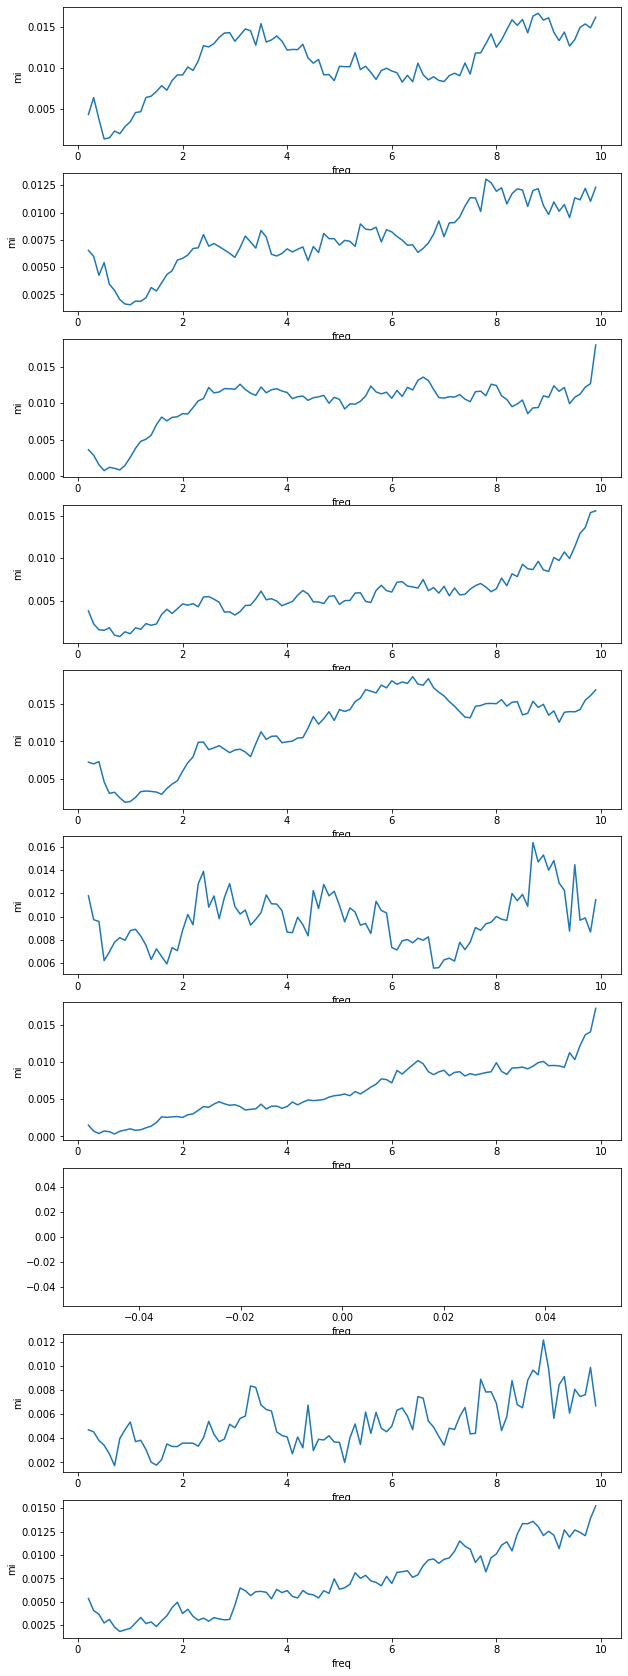

In [10]:
fig ,axs = plt.subplots(nrows = 10, figsize = (10,30))

for row, patient in enumerate(patients):
    ax = axs[row]
    sns.lineplot(data=df_all[df_all['patient'] == patient], x = 'freq', y = 'mi', ax=ax)

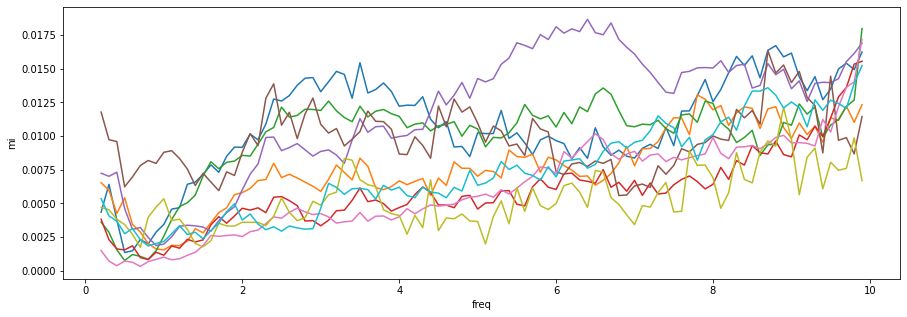

In [11]:
fig ,ax = plt.subplots(figsize = (15,5))
for patient in patients:
    sns.lineplot(data=df_all[df_all['patient'] == patient], x = 'freq', y = 'mi', ax=ax)
plt.show()


In [12]:
concat = []
for patient in patients:
    concat.append(df_all[(df_all['patient'] == patient) & (df_all['freq'] <= 6)].sort_values(by = 'mi', ascending = False).iloc[0,:])
best_modulant_by_patient = pd.concat(concat, axis = 1).T

In [13]:
best_modulant_by_patient

,patient,freq,mi
33,P1,3.5,0.015446
52,P2,5.4,0.008958
29,P3,3.1,0.012596
56,P4,5.8,0.006819
58,P5,6.0,0.018116
22,P6,2.4,0.013877
56,P7,5.8,0.007706
0,P8,0.2,NaN
31,P9,3.3,0.008325
51,P10,5.3,0.008103


In [14]:
best_modulant_by_patient.mean()

/tmp/ipykernel_1534086/1044040181.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_modulant_by_patient.mean()


freq    4.080000
mi      0.011105
dtype: float64

**Pour voir si cette modulante est modulée par la respi :**
- PAC de la respi sur les oscillations cérébrales
- Voir ce qui se passe par rapport à la possible modulante des fuseaux ?

In [15]:
da_data = xr.load_dataarray(f'../dataarray/da_staged_{patient}.nc').sel(stage = 'N2', chan = ['Fp2-C4','DEBIT'])

In [16]:
da_data

<xarray.DataArray (chan: 2, time: 2342400)>
array([[ 95.14649446,  95.97592585,  94.95048881, ..., 217.71074974,
        217.34368052, 216.66289558],
       [ 27.58601872,  27.91584779,  28.28031039, ...,  29.64699907,
         29.71136266,  29.61590715]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 9.15e+03 9.15e+03 9.15e+03
  * chan     (chan) object 'Fp2-C4' 'DEBIT'
    stage    <U2 'N2'

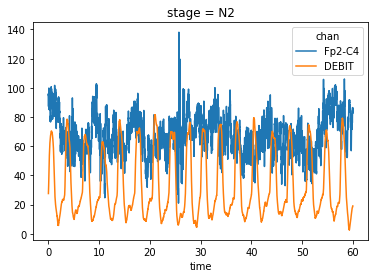

In [21]:
da_data.loc[:,0:60].plot.line(x='time', hue = 'chan')

In [19]:
filtered_resp = gh.filter_sig(da_data.loc['DEBIT',:].values, fs=srate, low = 0.1, high = 0.7)
phase_resp = gh.get_phase(filtered_resp)

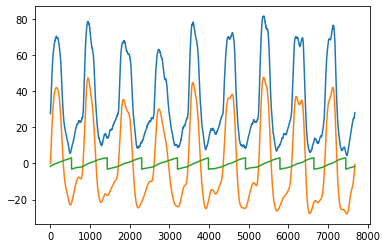

In [20]:
plt.plot(da_data.loc['DEBIT',:].values[0:srate*30])
plt.plot(filtered_resp[0:srate*30])
plt.plot(phase_resp[0:srate*30])

In [82]:
eeg_sig = da_data.loc['Fp2-C4',:].values
eeg_filtered = gh.filter_sig(eeg_sig, fs=srate, low = 3.5, high = 4.5)
envelope_eeg_filtered = gh.get_amp(eeg_filtered)

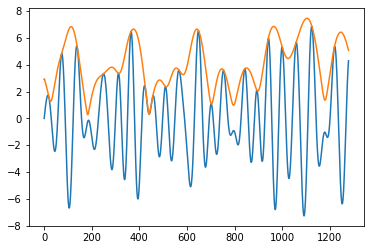

In [83]:
plt.plot(eeg_filtered[0:5*srate])
plt.plot(envelope_eeg_filtered[0:5*srate])

In [86]:
f, Pxx = signal.welch(envelope_eeg_filtered, fs = srate, nperseg = int(srate * 100))

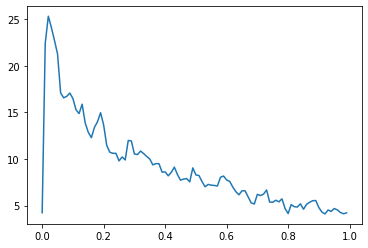

In [87]:
plt.plot(f[0:100], Pxx[0:100])

In [25]:
pac_distribution = gh.get_amplitude_distribution(phase_resp, envelope_eeg_filtered)

0.00010554455132515269

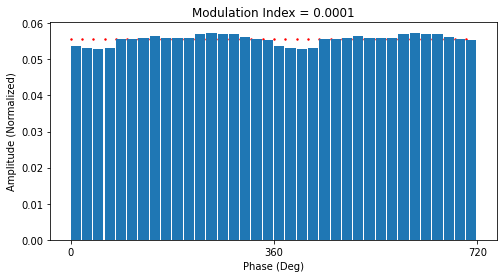

In [26]:
gh.Modulation_Index(pac_distribution, show = True)

In [27]:
def get_mi_fi_resp(phase_resp, eeg_sig, fi, half_width = 1, show = False):
    low = fi - half_width
    high = fi + half_width
    
    if low <= 0:
        low = None
    
    eeg_filtered = gh.filter_sig(eeg_sig, fs=srate, low = low, high = high)
    envelope_eeg_filtered = gh.get_amp(eeg_filtered)
    pac_distribution = gh.get_amplitude_distribution(phase_resp, envelope_eeg_filtered)
    mi = gh.Modulation_Index(pac_distribution, show = show)
    # return mi
    return mi, eeg_filtered, envelope_eeg_filtered

In [28]:
rows = []
da_features = None
freqs = np.arange(1,100,1)
for fi in freqs:
    if fi in np.arange(0,100,10):
        print(fi)
    for half_width in [0.1,0.5,1,2]:
        mi, eeg_filtered, envelope_eeg_filtered = get_mi_fi_resp(phase_resp, eeg_sig, fi=fi, half_width=half_width,  show =False)
        if da_features is None:
            da_features = gh.init_da({'features':['filtered','envelope'], 'width':[0.1,0.5,1,2], 'freq':freqs, 'time':gh.time_vector(eeg_filtered, srate)})
        da_features.loc['filtered',half_width,fi,:] = eeg_filtered
        da_features.loc['envelope',half_width,fi,:] = envelope_eeg_filtered
        rows.append([half_width, fi, mi])
df_mi_resp = pd.DataFrame(rows, columns = ['width','freq','mi'])

10
20
30
40
50
60
70
80
90


In [31]:
da_features = da_features.astype('float32')

In [66]:
da_features

<xarray.DataArray (features: 2, width: 4, freq: 99, time: 2342400)>
array([[[[-7.77156117e-15, -4.77694115e-03, -9.96959768e-03, ...,
          -1.08769774e-01, -5.45227081e-02, -1.50990331e-14],
         [-3.01980663e-14,  6.91520870e-02,  1.38582811e-01, ...,
          -1.14343655e+00, -5.73143303e-01, -6.26165786e-14],
         [-1.33226763e-14,  1.24882750e-01,  2.48987108e-01, ...,
          -1.68656635e+00, -8.45180452e-01, -3.21964677e-14],
         ...,
         [-3.23074900e-14, -1.74787402e-01,  2.77636915e-01, ...,
           3.23083878e-01, -2.30970785e-01, -5.87307980e-14],
         [ 3.33066907e-15, -1.84596404e-01,  2.79619038e-01, ...,
           3.23928505e-01, -2.32437506e-01,  1.89848137e-14],
         [-1.25455202e-14, -1.88307196e-01,  2.75279284e-01, ...,
           3.22360665e-01, -2.31664985e-01, -1.37667655e-14]],

        [[ 7.99360578e-15,  2.65681036e-02,  5.29901460e-02, ...,
          -3.66815388e-01, -1.83825895e-01, -5.99520433e-15],
         [-1.31006317e-14,  1.87930390e-02,  3.73393185e-02, ...,
          -1.56152987e+00, -7.82674849e-01, -3.93018951e-14],
         [ 2.56461519e-14,  2.93707728e-01,  5.84517777e-01, ...,
          -1.46263146e+00, -7.32378662e-01,  6.68354261e-14],
...
           3.33278805e-01,  3.27510238e-01,  2.07756847e-01],
         [ 1.77477092e-01,  2.67694771e-01,  2.71021813e-01, ...,
           3.36656988e-01,  3.33245248e-01,  2.09336042e-01],
         [ 1.76932290e-01,  2.66571313e-01,  2.68068373e-01, ...,
           3.37485850e-01,  3.35357249e-01,  2.08632648e-01]],

        [[ 5.91585205e+02,  5.15917725e+02,  5.16488098e+02, ...,
           5.47839905e+02,  5.48602539e+02,  6.21773621e+02],
         [ 5.91877197e+02,  5.15910461e+02,  5.16318420e+02, ...,
           5.49533386e+02,  5.49989624e+02,  6.22610901e+02],
         [ 2.57518768e+00,  2.42007518e+00,  2.21929622e+00, ...,
           3.61211586e+00,  3.36280251e+00,  2.93713331e+00],
         ...,
         [ 1.68391749e-01,  2.53568023e-01,  2.64270753e-01, ...,
           3.48110855e-01,  3.38707447e-01,  2.11222768e-01],
         [ 1.66263670e-01,  2.47774497e-01,  2.56030709e-01, ...,
           3.45574647e-01,  3.37084860e-01,  2.11240783e-01],
         [ 1.64683446e-01,  2.45946154e-01,  2.51838863e-01, ...,
           3.50108117e-01,  3.42108130e-01,  2.09729359e-01]]]],
      dtype=float32)
Coordinates:
  * features  (features) <U8 'filtered' 'envelope'
  * width     (width) float64 0.1 0.5 1.0 2.0
  * freq      (freq) int64 1 2 3 4 5 6 7 8 9 10 ... 91 92 93 94 95 96 97 98 99
  * time      (time) float64 0.0 0.003906 0.007812 ... 9.15e+03 9.15e+03

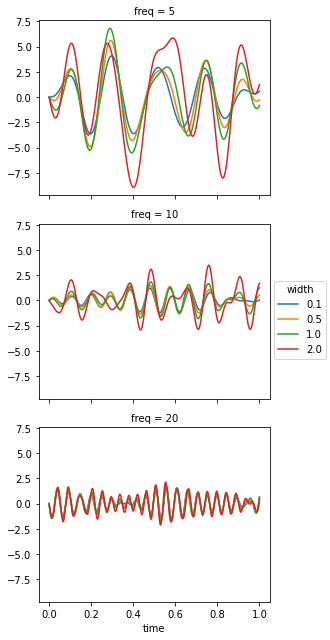

In [73]:
da_features.loc['filtered',:,[5,10,20],0:1].plot.line(x='time', hue = 'width', row = 'freq')

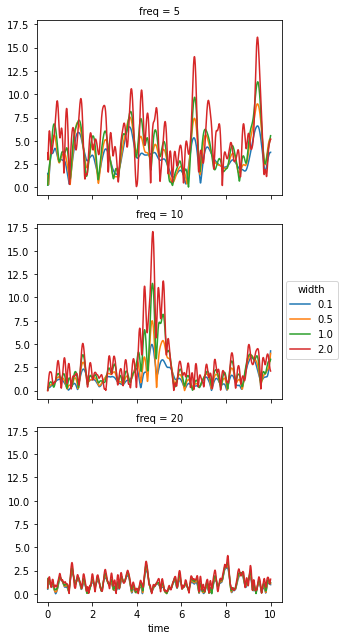

In [72]:
da_features.loc['envelope',:,[5,10,20],0:10].plot.line(x='time', hue = 'width', row = 'freq')

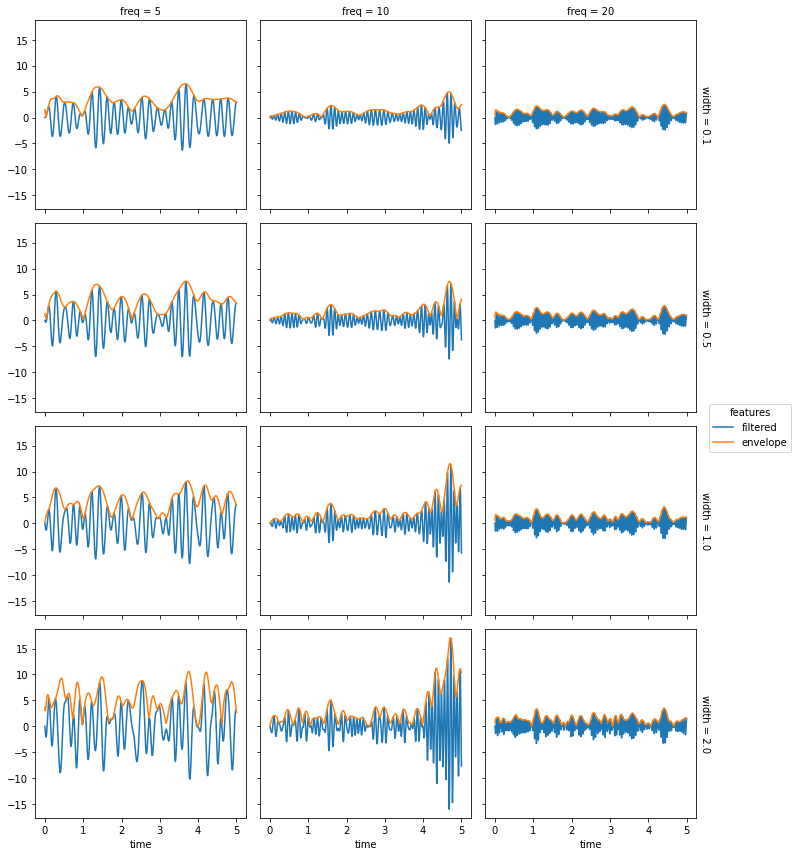

In [77]:
da_features.loc[:,:,[5,10,20],0:5].plot.line(x='time', hue = 'features', col = 'freq', row = 'width')

<AxesSubplot:xlabel='freq', ylabel='mi'>

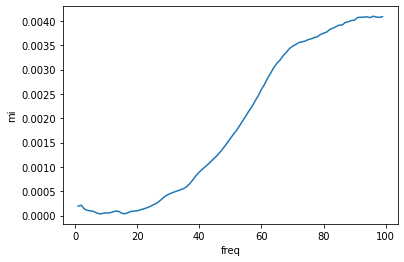

In [81]:
sns.lineplot(data=df_sel_bande, x='freq' , y = 'mi')

In [79]:
df_sel_bande = df_mi_resp[df_mi_resp['width'] == 0.5]

In [ ]:
get_mi_fi_resp(phase_resp, eeg_sig, fi=80,  show =True)

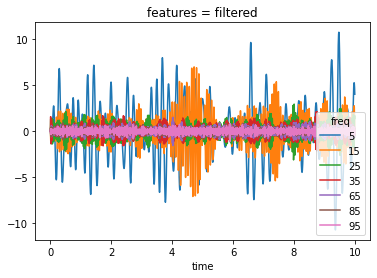

In [88]:
da_features.loc['filtered',[5,15,25,35,65,85,95],0:10].plot.line(x='time')

In [89]:
del da_features

In [90]:
da_features

NameError: name 'da_features' is not defined

In [41]:
eeg_sig = da_data.loc['Fp2-C4',:].values

In [51]:
eeg_sig_filtered = gh.filter_sig(eeg_sig , fs =srate , low = 1.8 , high =4)

In [52]:
eeg_sig_filtered_phase = gh.get_phase(eeg_sig_filtered)

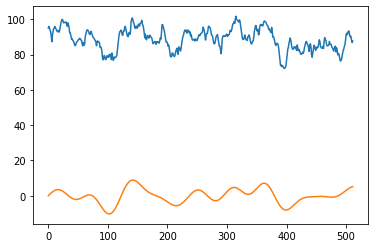

In [53]:
plt.plot(eeg_sig[0:2*srate])
plt.plot(eeg_sig_filtered[0:2*srate])

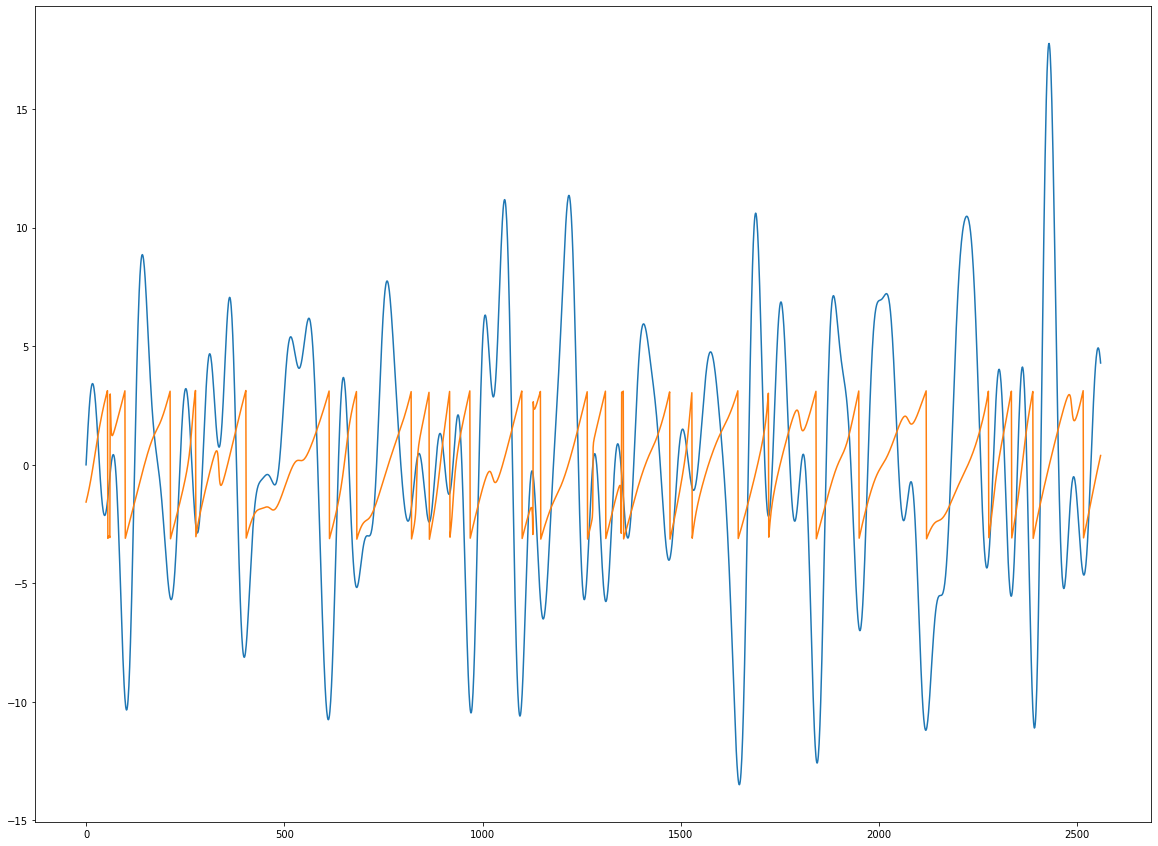

In [54]:
plt.figure(figsize = (20,15))
plt.plot(eeg_sig_filtered[0:10*srate])
plt.plot(eeg_sig_filtered_phase[0:10*srate])

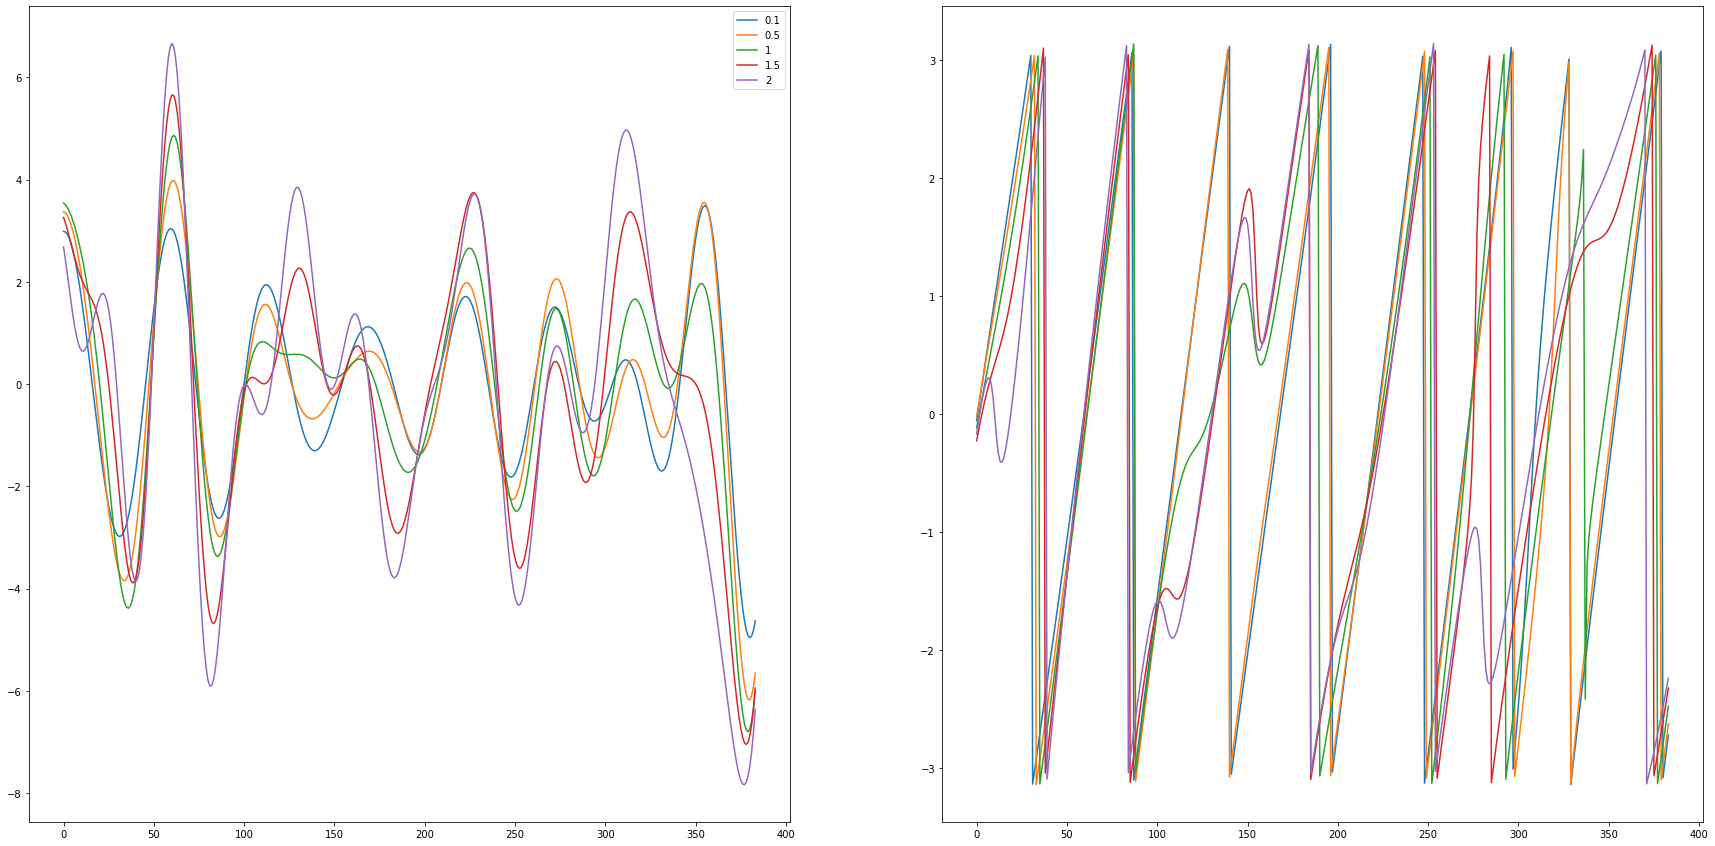

In [65]:
fig, axs = plt.subplots(ncols = 2 , figsize = (30,15))
fi = 5
for width in [0.1 , 0.5 , 1 , 1.5, 2]:
    eeg_sig_filtered = gh.filter_sig(eeg_sig , fs =srate , low = fi - width  , high = fi + width)
    eeg_sig_filtered_phase = gh.get_phase(eeg_sig_filtered)
    axs[0].plot(eeg_sig_filtered[5*srate:int(6.5*srate)], label = width)
    axs[1].plot(eeg_sig_filtered_phase[5*srate:int(6.5*srate)], label = width)
axs[0].legend()
plt.show()